<a href="https://colab.research.google.com/github/OkoksNeDam/computer-vision-models-analysis/blob/main/cifar10/TwoLayerCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training two-layer convolutional NN.

## Load data

In [46]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import sklearn.model_selection
import sklearn.metrics
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns
import copy
import random
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [79]:
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(SEED)
g = torch.Generator()
g.manual_seed(SEED)

In [80]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Split dataset and define dataloaders

In [81]:
torch.manual_seed(42)

TRAIN_SIZE = 40_000
VAL_SIZE = 10_000
TEST_SIZE = 10_000

BATCH_SIZE = 32
NUM_WORKERS = 2

train, val, _ = torch.utils.data.random_split(train_set, [TRAIN_SIZE, VAL_SIZE, len(train_set) - (TRAIN_SIZE + VAL_SIZE)])
test, _ = torch.utils.data.random_split(test_set, [TEST_SIZE, len(test_set) - TEST_SIZE])

train_dataloader = torch.utils.data.DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker
)

test_dataloader = torch.utils.data.DataLoader(
    test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker
)

val_dataloader = torch.utils.data.DataLoader(
    val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker
)

## Visualize dataset

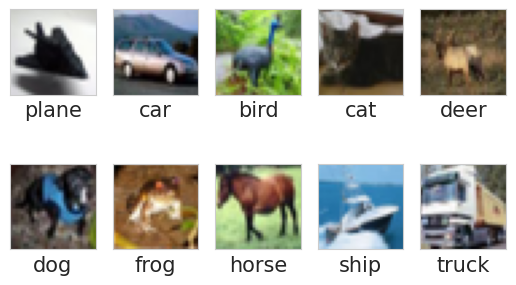

In [82]:
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
fig, axes = plt.subplots(2, 5)
plt.subplots_adjust(top = 0.7)
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i].reshape((32,32,3)))
    i += 1

## Function for loss and accuracy visualization

In [83]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, val_losses, train_accuracies, val_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

## Implement neural network

In [84]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, maxpool_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(maxpool_size, maxpool_size)
        )

    def forward(self, X):
        return self.block(X)

class TwoLayerCNN(nn.Module):
    def __init__(self, architecture_config):
        super().__init__()
        self.architecture_config = architecture_config
        self.model = self._create_model(self.architecture_config)

    def forward(self, X):
        return self.model(X)

    def _create_model(self, architecture_config):
        layers = []
        for x in architecture_config:
            if x == "relu":
                layers += [
                    nn.ReLU()
                ]
            elif x == "F":
                layers += [
                    nn.Flatten(1)
                ]
            elif len(x) == 4:
                layers += [
                    ConvBlock(in_channels=x[0], out_channels=x[1], kernel_size=x[2], maxpool_size=x[3])
                ]
            else:
                layers += [
                    nn.Linear(in_features=x[0], out_features=x[1])
                ]
        return nn.Sequential(*layers)

## Learning cycle

In [85]:
def train(model, criterion, optimizer, train_loader, val_loader, scheduler=None, n_epochs=5):
    torch.manual_seed(42)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    best_model = None
    best_accuracy = 0.0

    for epoch in range(n_epochs):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()
        for imgs, labels in tqdm(train_loader, desc='Training'):
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            train_accuracy += torch.sum(torch.argmax(logits.cpu(), dim=1) == labels.cpu()).item()

        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        val_loss, val_accuracy = 0.0, 0.0
        model.eval()
        for imgs, labels in tqdm(val_loader, desc='Validating'):
            imgs = imgs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(imgs)
                loss = criterion(logits, labels)

            val_loss += loss.item()
            val_accuracy += torch.sum(torch.argmax(logits.cpu(), dim=1) == labels.cpu()).item()

        val_loss /= len(val_loader)

        if scheduler is not None:
            scheduler.step(val_loss)

        val_accuracy /= len(val_loader.dataset)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = copy.deepcopy(model)

        val_losses += [val_loss]
        val_accuracies += [val_accuracy]

        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

    return torch.min(torch.tensor(val_losses)).item(), best_accuracy, best_model

## Architecture config

In [86]:
architecture_config = [
    # ConvBlock: in_channels x out_channels x kernel_size x maxpool_size.
    (3, 64, 5, 2),
    (64, 32, 3, 2),
    # nn.Flatten(1).
    "F",
    # Linear: in_features x out_features.
    (32 * 8 * 8, 1024),
    "relu",
    (1024, 10)
]

## Tuning hyperparameters

Let's try model with $lr = 1e-4$

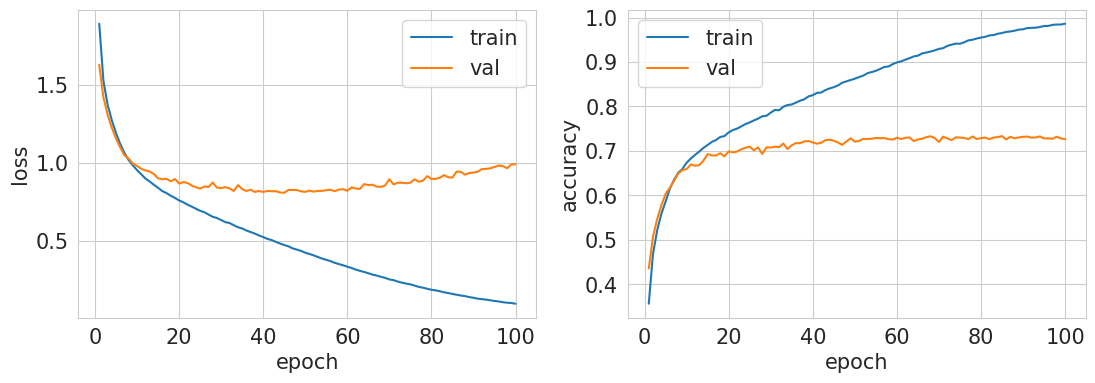

In [92]:
NUM_EPOCHS = 100
momentum = 0.9
lr = 1e-4

model = TwoLayerCNN(architecture_config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr)
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)

In [93]:
best_val_loss, best_val_accuracy

(0.8073157072067261, 0.7334)

## Estimate model on test data.

In [ ]:
test_loss, test_accuracy = 0.0, 0.0

best_model.eval()
for imgs, labels in tqdm(test_dataloader, desc='Testing'):
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = best_model(imgs)
        loss = criterion(logits, labels)

    test_loss += loss.item()
    test_accuracy += torch.sum(torch.argmax(logits.cpu(), dim=1) == labels.cpu()).item()

test_loss /= len(test_dataloader)
test_accuracy /= len(test_dataloader.dataset)
test_loss, test_accuracy

Testing: 100%|██████████| 313/313 [00:03<00:00, 96.06it/s] 


(0.8055830032775958, 0.7313)